In [132]:
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [2]:
twitter_df = pd.read_csv('twitter-archive-enhanced.csv')
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [3]:
# access token and secret 

import tweepy
from tweepy import OAuthHandler

consumer_key = 'wpgUFCCNh1ryE03ZAm6f5g1uU'
consumer_secret = 'w8Uczb8i05FQruhuS0xHRjGuNDiGHDhMwDpFvzF65iXl5ZkDfL'
access_token = '1249981086660268038-PDyN5qDBVlFl8zrRF1IBLskjezbjyC'
access_secret = 'vSphlMTWcOhUOwtZAUGCumEafOAlnaLYSzsjoyx9qpKBq'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [4]:
tweet_ids = twitter_df.tweet_id.values
len(tweet_ids)

count = 0
fails_dict = {}
start = timer()

with open('tweet_json.txt', 'w', encoding = 'utf8') as outfile:
    
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended', 
                                   wait_on_rate_limit_notify = True, 
                                   wait_on_rate_limit = True)
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass

end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Rate limit reached. Sleeping for: 603


Success
902: 758474966123810816
Success
903: 758467244762497024
Success
904: 758405701903519748
Success
905: 758355060040593408
Success
906: 758099635764359168
Success
907: 758041019896193024
Success
908: 757741869644341248
Success
909: 757729163776290825
Success
910: 757725642876129280
Success
911: 757611664640446465
Success
912: 757597904299253760
Success
913: 757596066325864448
Success
914: 757400162377592832
Success
915: 757393109802180609
Success
916: 757354760399941633
Success
917: 756998049151549440
Success
918: 756939218950160384
Success
919: 756651752796094464
Success
920: 756526248105566208
Success
921: 756303284449767430
Success
922: 756288534030475264
Success
923: 756275833623502848
Success
924: 755955933503782912
Success
925: 755206590534418437
Success
926: 755110668769038337
Success
927: 754874841593970688
Success
928: 754856583969079297
Success
929: 754747087846248448
Success
930: 754482103782404096
Success
931: 754449512966619136
Success
932: 754120377874386944
Success


Rate limit reached. Sleeping for: 600


Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
1812: 676819651066732545
Success
1813: 676811746707918848
Success
1814: 676776431406465024
Success
1815: 676617503762681856
Success
1816: 676613908052996102
Success
1817: 676606785097199616
Success
1818: 676603393314578432
Success
1819: 676593408224403456
Success
1820: 676590572941893632
Success
1821: 676588346097852417
Success
1822: 676582956622721024
Success
1823: 676575501977128964
Success
1824: 676533798876651520
Success
1825: 676496375194980353
Success
1826: 676470639084101634
Success
1827: 676440007570247681
Success
1828: 676430933382295552
Success
1829: 676263575653122048
Success
1830: 676237365392908289
Success
1831: 676219687039057920
Success
18

In [123]:
#to read json in a dataframe with the columns specified

with open('tweet_json.txt', 'r') as f:
    twitter_json = pd.read_json(f, lines=True)
twitter_json = twitter_json[['id','favorite_count','retweet_count']]
twitter_json.head(1)

,id,favorite_count,retweet_count
0,892420643555336193,36401,7746


In [107]:
image_predictions = pd.read_csv('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', sep = '\t')

In [108]:
image_predictions.to_csv('test.csv', index = False)

In [109]:
# to merge all dataframes to populate one table for easy review

twitter_one = pd.merge(twitter_df, twitter_json, left_on='tweet_id', right_on='id', how='left').drop('id', axis=1)
twitter = pd.merge(twitter_one, image_predictions, on = 'tweet_id')

In [110]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   int64  
 11  rating_denominator          2075 non-null   int64  
 12  name                        2075 non-null   object 
 13  doggo                       2075 

In [111]:
twitter.favorite_count.isna().sum().sum()

16

In [112]:
#Tidiness: Fill the NaN value for consistency.
twitter.favorite_count.fillna(0, inplace= True)
twitter.retweet_count.fillna(0, inplace = True)

In [113]:
# Quality Issue: to remove rows that contain retweets by selecting rows that contain the string "RT"

twitter = twitter[~twitter.text.str.contains('RT @')]

In [114]:
#Quality Issue: Once the rows with retweets got deleted, these columns will have no value. Hence, the deletion.

twitter.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace = True)

In [115]:
#Quality Issue: Rows contain missing values.

twitter.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1, inplace = True)

In [121]:
#Quality Issue: Difference datatypes. To change them to appropriate dtypes.
twitter.timestamp = pd.to_datetime(twitter.timestamp)

twitter['favorite_count'] = twitter['favorite_count'].astype(int)

twitter['retweet_count'] = twitter['retweet_count'].astype(int)

##### Quality Issues:
1. Column 'name' contains peculiar names like 'a' and 'none'.
2. Column 'expanded url' contains inconsistent url data. Some rows have more than one url.
3. Rating numerator have values above 100 and more, above the usual range. 


##### Tidiness:
1. Column 'name' contains names that are not consistently capitalised.
2. Columns 'img_num', 'p1' to 'p3', 'p1_conf' to 'p3_conf' and 'p1_dog' to 'p3_dog' can be grouped/collapsed as/into one big column.
3. Dog stages can be grouped as one column.

In [126]:
twitter.to_csv('twitter_archive_master.csv', index= False)

In [127]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1994 non-null   int64              
 1   timestamp           1994 non-null   datetime64[ns, UTC]
 2   source              1994 non-null   object             
 3   text                1994 non-null   object             
 4   expanded_urls       1994 non-null   object             
 5   rating_numerator    1994 non-null   int64              
 6   rating_denominator  1994 non-null   int64              
 7   name                1994 non-null   object             
 8   doggo               1994 non-null   object             
 9   floofer             1994 non-null   object             
 10  pupper              1994 non-null   object             
 11  puppo               1994 non-null   object             
 12  favorite_count      1994 non-null 

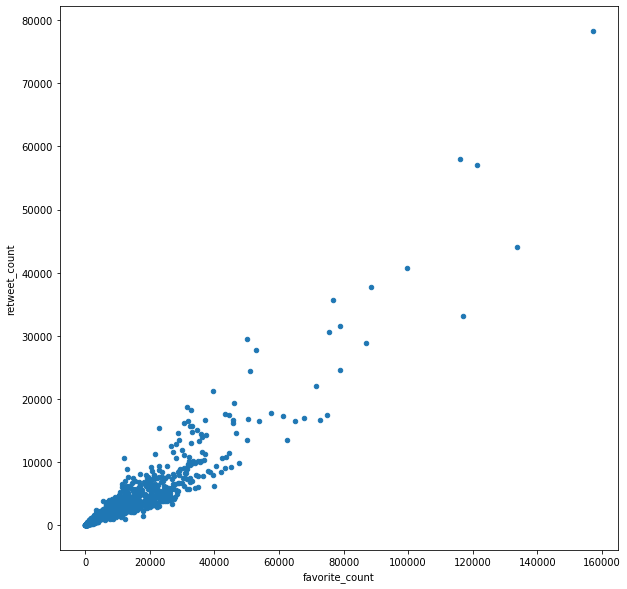

In [146]:
# to find out how many of the favourites were retweeted.

twitter.plot(kind= 'scatter', x = 'favorite_count', y = 'retweet_count', figsize = (10,10))
plt.show()

The plot shows a concregation within the 40000 around which the tweets were retweeted. The most favourite has been the most retweeted. However, the data shows that most retweets do not go beyond a certain range.

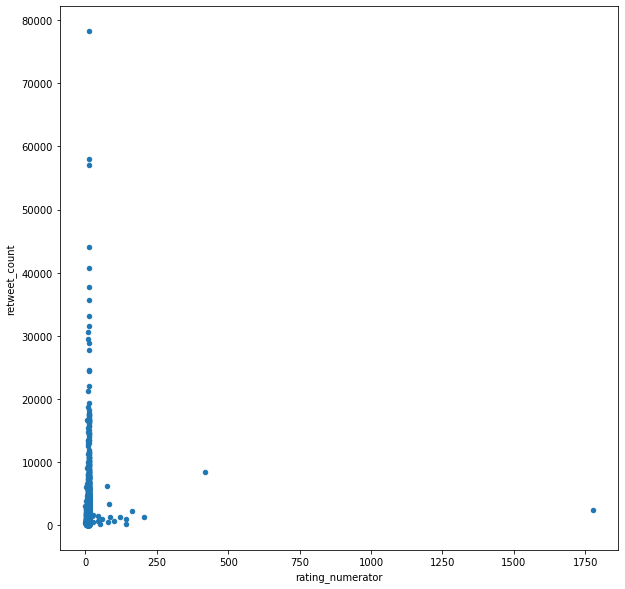

In [152]:
# how the retweets stand against the rating_numerator

twitter.plot(kind= 'scatter', x = 'rating_numerator', y = 'retweet_count', figsize = (10,10))
plt.show()

The plot shows outliers. The highest rating were not retweet the most. Most retweets received ratings under quarter of 250.

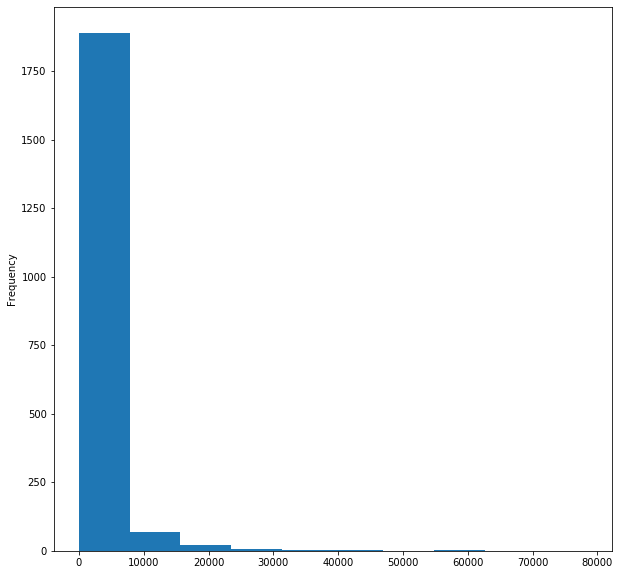

In [151]:
# to show the frequency of retweets.

twitter['retweet_count'].plot(kind= 'hist', figsize = (10,10))
plt.show()

There is missing data just before and after the 50000 retweets.